In [1]:
import matplotlib.pyplot as plt
import numpy as np

from datasets.mnist import MNIST

from models.cae_model import CAE
from models.conv_model import CNN

from train import train_ae, train_cnn

from cem import ContrastiveExplanationMethod

In [2]:
dataset = MNIST()
# dataset = FashionMNIST()

# Training the classifier

In [3]:
cnn = CNN()

train_cnn(cnn, dataset, iterations=2, lr=0.001, device='cpu', save_fn='mnist-cnn', load_path="./models/saved_models/b_mnist-cnn.h5")

In [4]:
images, _ = dataset.get_batch()

output = cnn(images)

images = images.numpy()
output = output.detach().numpy()


D:\david\Coding\uva-fact-ai\models\conv_model.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.functional.softmax(out)


# Training the autoencoder

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [5]:
# Train or load autoencoder
cae = CAE()

train_ae(cae, dataset, iterations=2, save_fn="mnist-cae", load_path="./models/saved_models/b-mnist-cae.h5")

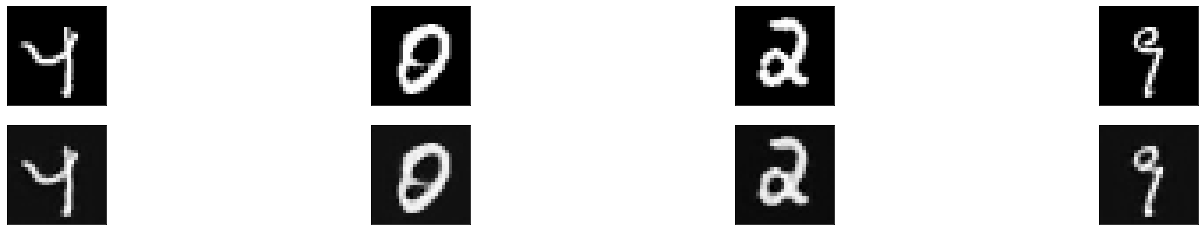

In [6]:
# obtain one batch of test images
images, _ = dataset.get_batch()

#images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = cae(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
# output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Contrastive Explanation Method

In [7]:
CEM = ContrastiveExplanationMethod(cnn, cae, iterations=50, n_searches=9, kappa=10, gamma=100)

In [8]:
# obtain one sample
image, _ = dataset.get_sample()

CEM.fista(image, mode="PN")

search no: 0
search iteration: 1
current loss: 166.45162963867188
current y grad: -299.770751953125
current y: 29.97707748413086
current delta: 0.0
has reached optimum: True
current c: 10

search no: 0
search iteration: 2
current loss: 3757.620849609375
current y grad: 4715.90234375
current y: 220.90956115722656
current delta: 176.7276611328125
has reached optimum: True
current c: 10

search no: 0
search iteration: 3
current loss: 2761.74267578125
current y grad: 5231.19189453125
current y: 187.51870727539062
current delta: 184.0045166015625
has reached optimum: True
current c: 10

search no: 0
search iteration: 4
current loss: 1990.142822265625
current y grad: 4456.22216796875
current y: 155.72225952148438
current delta: 164.4163360595703
has reached optimum: True
current c: 10

search no: 0
search iteration: 5
current loss: 1407.984130859375
current y grad: 5051.62451171875
current y: 128.78652954101562
current delta: 138.0113525390625
has reached optimum: True
current c: 10

search 

current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 10

search no: 0
search iteration: 42
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 10

search no: 0
search iteration: 43
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 10

search no: 0
search iteration: 44
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 10

search no: 0
search iteration: 45
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 10

search no: 0
s

current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 5.05

search no: 1
search iteration: 32
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 5.05

search no: 1
search iteration: 33
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 5.05

search no: 1
search iteration: 34
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 5.05

search no: 1
search iteration: 35
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 5.05

sear

has reached optimum: True
current c: 2.5749999999999997

search no: 2
search iteration: 20
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 2.5749999999999997

search no: 2
search iteration: 21
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 2.5749999999999997

search no: 2
search iteration: 22
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 2.5749999999999997

search no: 2
search iteration: 23
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 2.5749999999999997

search no: 2
search iteration: 24
current loss: 1288.4395751953

current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.07013702392578
has reached optimum: True
current c: 1.3375

search no: 3
search iteration: 8
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 1.3375

search no: 3
search iteration: 9
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 1.3375

search no: 3
search iteration: 10
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 1.3375

search no: 3
search iteration: 11
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 1.3375

search no: 3
search iteratio

current delta: 113.0254898071289
has reached optimum: True
current c: 1.3375

search no: 3
search iteration: 47
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 1.3375

search no: 3
search iteration: 48
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 1.3375

search no: 3
search iteration: 49
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 1.3375

search no: 3
search iteration: 50
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 1.3375

search no: 4
search iteration: 1
current loss: 166.45162963867188
current y grad: -299.770

search no: 4
search iteration: 36
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.71875

search no: 4
search iteration: 37
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.71875

search no: 4
search iteration: 38
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.71875

search no: 4
search iteration: 39
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.71875

search no: 4
search iteration: 40
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
h

current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.409375

search no: 5
search iteration: 26
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.409375

search no: 5
search iteration: 27
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.409375

search no: 5
search iteration: 28
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.409375

search no: 5
search iteration: 29
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
curre

current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.2546875

search no: 6
search iteration: 15
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.2546875

search no: 6
search iteration: 16
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.2546875

search no: 6
search iteration: 17
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.2546875

search no: 6
search iteration: 18
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
c

current c: 0.17734375000000002

search no: 7
search iteration: 3
current loss: 2761.74267578125
current y grad: 5231.19189453125
current y: 187.51870727539062
current delta: 184.0045166015625
has reached optimum: True
current c: 0.17734375000000002

search no: 7
search iteration: 4
current loss: 1990.142822265625
current y grad: 4456.22216796875
current y: 155.72225952148438
current delta: 164.4163360595703
has reached optimum: True
current c: 0.17734375000000002

search no: 7
search iteration: 5
current loss: 1407.984130859375
current y grad: 5051.62451171875
current y: 128.78652954101562
current delta: 138.0113525390625
has reached optimum: True
current c: 0.17734375000000002

search no: 7
search iteration: 6
current loss: 1285.96533203125
current y grad: 3756.2451171875
current y: 113.17430877685547
current delta: 119.16001892089844
has reached optimum: True
current c: 0.17734375000000002

search no: 7
search iteration: 7
current loss: 1288.4395751953125
current y grad: 3717.9709472

current c: 0.17734375000000002

search no: 7
search iteration: 40
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.17734375000000002

search no: 7
search iteration: 41
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.17734375000000002

search no: 7
search iteration: 42
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.17734375000000002

search no: 7
search iteration: 43
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.17734375000000002

search no: 7
search iteration: 44
current loss: 1288.4395751953125
current y grad: 3

search no: 8
search iteration: 28
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.138671875

search no: 8
search iteration: 29
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.138671875

search no: 8
search iteration: 30
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.138671875

search no: 8
search iteration: 31
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113.0254898071289
has reached optimum: True
current c: 0.138671875

search no: 8
search iteration: 32
current loss: 1288.4395751953125
current y grad: 3717.970947265625
current y: 113.0254898071289
current delta: 113

In [9]:
# import os
# os.environ["PATH"] += os.pathsep + 'D:/Program Files/Graphviz/bin'

# from torchviz import make_dot
# make_dot(CEM.loss).view()

In [10]:
print(CEM.prev_deltas[-1])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

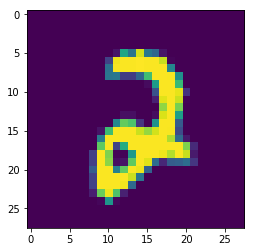

In [11]:
plt.imshow(image.squeeze())

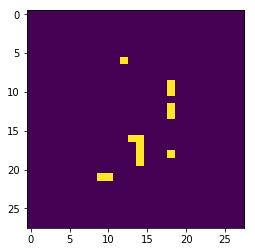

In [12]:
plt.imshow(CEM.best_delta.view(28,28) - image.squeeze())

In [19]:
cnn(CEM.best_delta.view(1,28,28) - image.squeeze()).detach()

tensor([[0.0052, 0.0765, 0.6493, 0.0222, 0.0395, 0.0144, 0.0441, 0.1079, 0.0254,
         0.0156]])

In [18]:
np.argmax(cnn(image.squeeze(-1)).detach())

tensor(2)